# 📊 EMG 数据集深度探索

本 Notebook 将详细展示如何读取和分析 HDF5 格式的 EMG（表面肌电信号）数据集，包括：

- 🗂️ 文件结构探索
- 📈 EMG 多通道信号可视化
- 🎯 手势标签和提示点分析
- 🔍 信号与手势的对应关系
- 📊 不同手势的 EMG 模式对比

**数据集信息**：
- 采样率：2000 Hz
- 通道数：16 个 EMG 通道
- 手势类型：食指、中指、拇指等动作

## 1. 导入必要的库

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

# 设置中文字体（如果需要）
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# 数据文件路径
DATA_FILE = Path.home() / "emg_data" / "discrete_gestures_user_000_dataset_000.hdf5"

print("✓ 库导入成功")
print(f"✓ 数据文件路径: {DATA_FILE}")
print(f"✓ 文件是否存在: {DATA_FILE.exists()}")

✓ 库导入成功
✓ 数据文件路径: /Users/chenee/emg_data/discrete_gestures_user_000_dataset_000.hdf5
✓ 文件是否存在: True


## 2. 探索 HDF5 文件结构

HDF5 是一种层次化的数据格式，让我们先看看文件里都有什么。

In [2]:
# 打开 HDF5 文件
f = h5py.File(DATA_FILE, 'r')

print("=" * 60)
print("📁 HDF5 文件结构")
print("=" * 60)

# 查看顶层键
print(f"\n顶层包含: {list(f.keys())}\n")

# 详细查看每个部分
for key in f.keys():
    item = f[key]
    print(f"【{key}】")
    
    if isinstance(item, h5py.Group):
        print(f"  类型: Group (分组)")
        print(f"  包含: {list(item.keys())}")
    elif isinstance(item, h5py.Dataset):
        print(f"  类型: Dataset (数据集)")
        print(f"  形状: {item.shape}")
        print(f"  数据类型: {item.dtype}")
        if item.dtype.names:
            print(f"  字段: {item.dtype.names}")
    print()

print("=" * 60)

📁 HDF5 文件结构

顶层包含: ['data', 'prompts', 'stages']

【data】
  类型: Dataset (数据集)
  形状: (5480192,)
  数据类型: [('emg', '<f4', (16,)), ('time', '<f8')]
  字段: ('emg', 'time')

【prompts】
  类型: Group (分组)
  包含: ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values']

【stages】
  类型: Group (分组)
  包含: ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values']



## 3. 读取 EMG 信号数据

`data` 是一个复合数据类型，包含了 EMG 信号和时间戳。

In [3]:
# 读取前 10000 个样本 (5秒的数据)
data = f['data'][:10000]

# 提取 EMG 和时间戳
emg = np.array([d[0] for d in data])   # EMG 数据
time = np.array([d[1] for d in data])  # 时间戳

# 转换为相对时间（从0开始）
t0 = time[0]
time_rel = time - t0

print("=" * 60)
print("📊 EMG 数据基本信息")
print("=" * 60)
print(f"\nEMG 数据形状: {emg.shape}")
print(f"  - {emg.shape[0]:,} 个样本")
print(f"  - {emg.shape[1]} 个通道")
print(f"\n时间信息:")
print(f"  - 起始时间: {time[0]:.3f}")
print(f"  - 结束时间: {time[-1]:.3f}")
print(f"  - 时长: {time_rel[-1]:.3f} 秒")
print(f"  - 采样率: {1/(time[1]-time[0]):.0f} Hz")
print(f"\n信号统计 (通道 0):")
print(f"  - 均值: {np.mean(emg[:, 0]):.4f}")
print(f"  - 标准差: {np.std(emg[:, 0]):.4f}")
print(f"  - 最小值: {np.min(emg[:, 0]):.4f}")
print(f"  - 最大值: {np.max(emg[:, 0]):.4f}")
print("=" * 60)

📊 EMG 数据基本信息

EMG 数据形状: (10000, 16)
  - 10,000 个样本
  - 16 个通道

时间信息:
  - 起始时间: 1633014930.533
  - 结束时间: 1633014935.531
  - 时长: 4.998 秒
  - 采样率: 2000 Hz

信号统计 (通道 0):
  - 均值: -0.0007
  - 标准差: 2.0676
  - 最小值: -13.6897
  - 最大值: 31.2262


## 4. 读取手势标签数据

`prompts` 包含了所有手势触发的时间点和名称。

In [4]:
# 使用 pandas 读取 prompts 表
df_prompts = pd.read_hdf(DATA_FILE, key='prompts')

# 计算相对时间
df_prompts['rel_time'] = df_prompts['time'] - t0

print("=" * 60)
print("🎯 手势提示点信息")
print("=" * 60)
print(f"\n总提示点数: {len(df_prompts)}")
print(f"列名: {list(df_prompts.columns)}")
print(f"\n前 10 个提示点:")
print(df_prompts[['name', 'rel_time']].head(10).to_string(index=False))
print("\n" + "=" * 60)

🎯 手势提示点信息

总提示点数: 1900
列名: ['name', 'time', 'rel_time']

前 10 个提示点:
          name   rel_time
  middle_press 261.015693
middle_release 261.760691
   index_press 262.795746
 index_release 262.985775
   index_press 264.305771
 index_release 264.395807
   index_press 264.660820
 index_release 264.780837
   index_press 265.850799
 index_release 265.940795



## 5. 统计不同手势类型

手势类型统计:
name
middle_press      400
middle_release    400
index_press       400
index_release     400
thumb_in           60
thumb_up           60
thumb_out          60
thumb_down         60
thumb_click        60
Name: count, dtype: int64


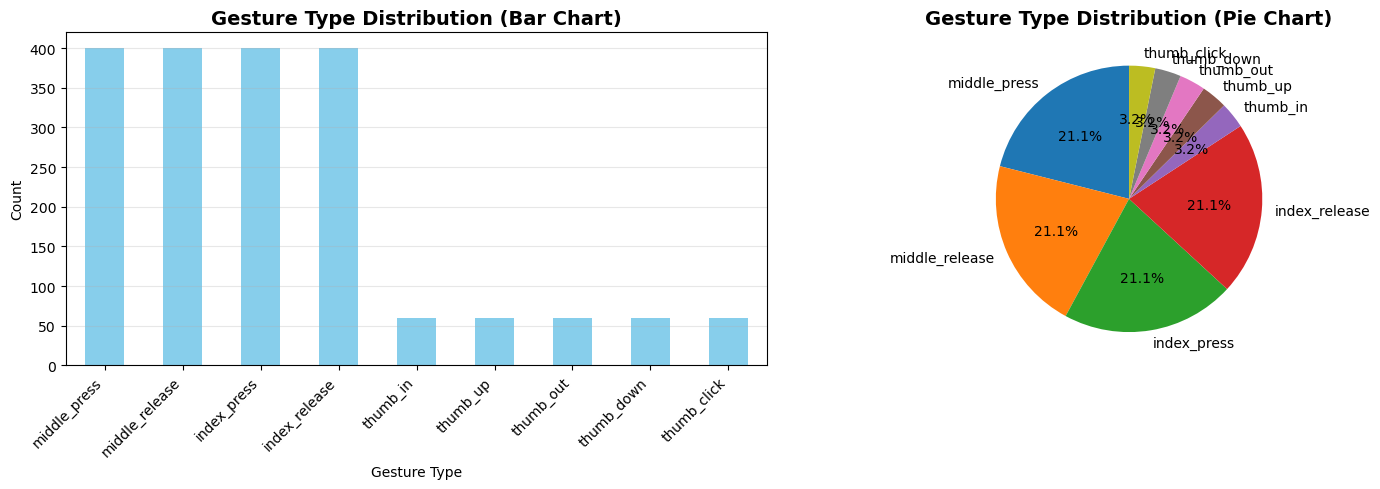


共有 9 种不同的手势类型


In [5]:
# 统计手势类型
gesture_counts = df_prompts['name'].value_counts()

print("手势类型统计:")
print(gesture_counts)

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 柱状图
gesture_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Gesture Type Distribution (Bar Chart)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Gesture Type')
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 饼图
ax2.pie(gesture_counts.values, labels=gesture_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Gesture Type Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n共有 {len(gesture_counts)} 种不同的手势类型")

## 6. 可视化 EMG 多通道信号

让我们查看 EMG 16个通道的原始信号波形。

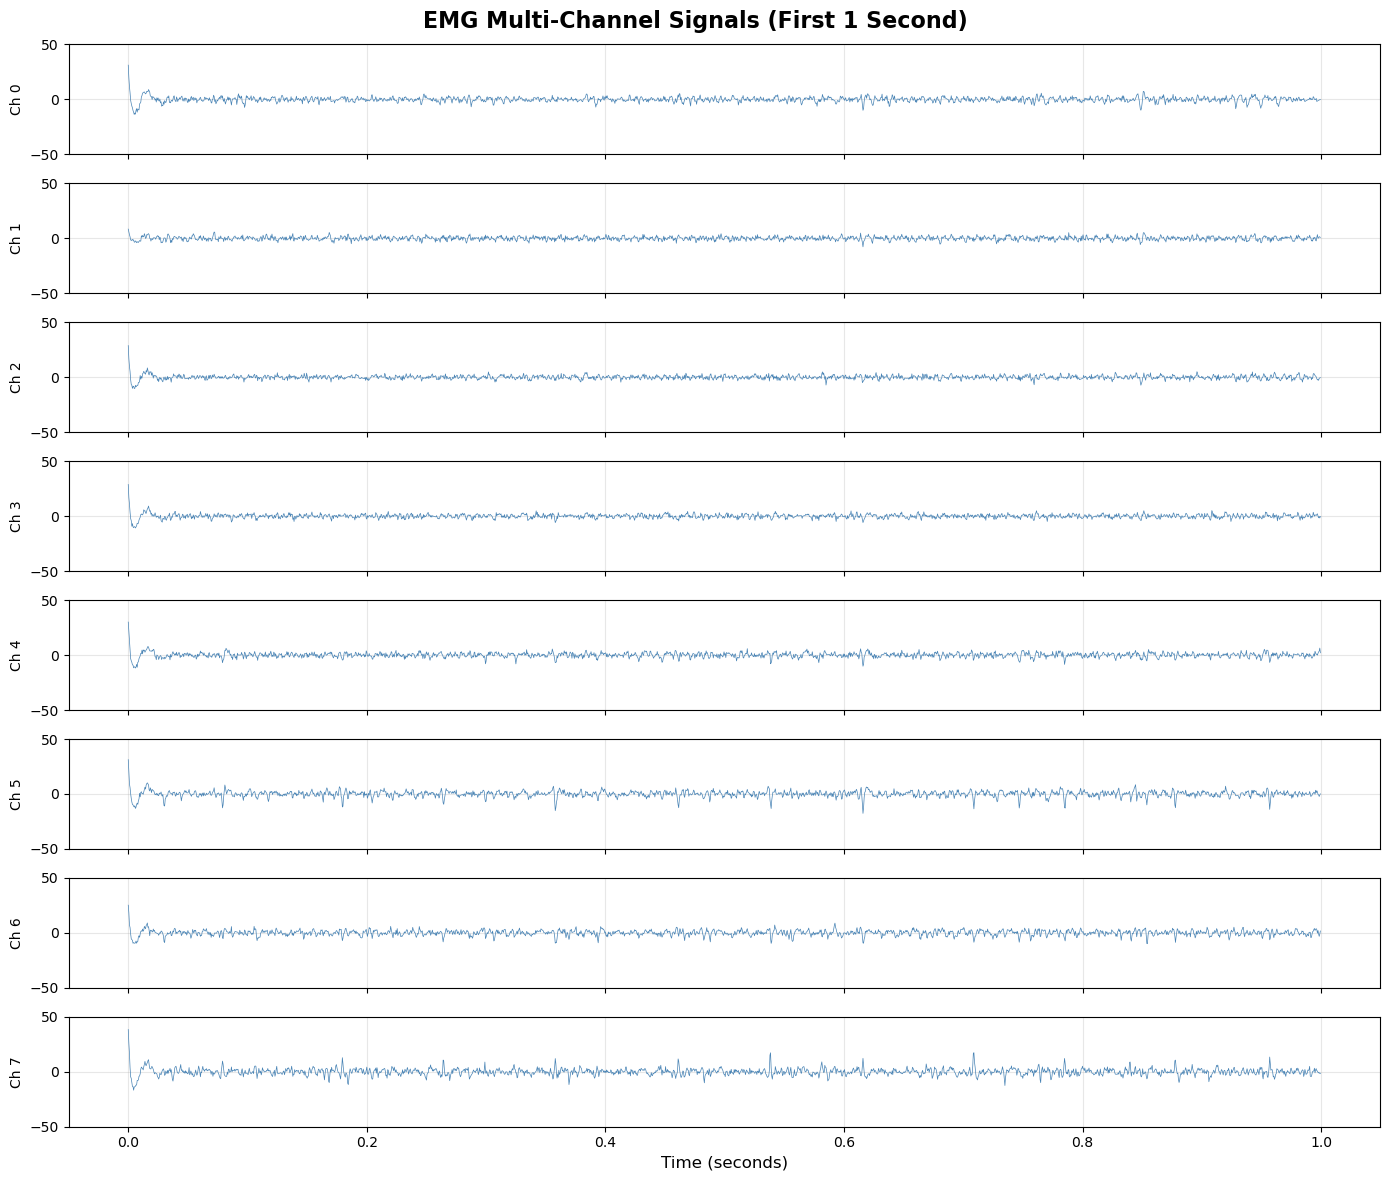

In [6]:
# 绘制前 8 个通道的信号（1秒的数据）
num_samples = 2000  # 1秒
emg_segment = emg[:num_samples, :8]  # 前8个通道
time_segment = time_rel[:num_samples]

fig, axes = plt.subplots(8, 1, figsize=(14, 12), sharex=True)
fig.suptitle('EMG Multi-Channel Signals (First 1 Second)', fontsize=16, fontweight='bold')

for i in range(8):
    axes[i].plot(time_segment, emg_segment[:, i], linewidth=0.5, color='steelblue')
    axes[i].set_ylabel(f'Ch {i}', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim([-50, 50])  # 设置统一的 y 轴范围

axes[-1].set_xlabel('Time (seconds)', fontsize=12)
plt.tight_layout()
plt.show()

## 7. EMG 信号与手势标签的对应关系

让我们看看 EMG 信号在手势动作发生时的变化。

In [7]:
# 读取包含多个手势的时间段（比如 260-270 秒）
def get_time_window(start_time, duration):
    """获取指定时间窗口的数据"""
    all_time = f['data']['time'][:]
    abs_start = t0 + start_time
    abs_end = t0 + start_time + duration
    
    start_idx = np.searchsorted(all_time, abs_start)
    end_idx = np.searchsorted(all_time, abs_end)
    
    data_seg = f['data'][start_idx:end_idx]
    emg_seg = np.array([d[0] for d in data_seg])
    time_seg = np.array([d[1] for d in data_seg]) - t0
    
    return emg_seg, time_seg

# 读取 260-270 秒的数据
emg_window, time_window = get_time_window(260, 10)

# 找到这个时间窗口内的手势
mask = (df_prompts['rel_time'] >= 260) & (df_prompts['rel_time'] <= 270)
prompts_in_window = df_prompts[mask]

print(f"在 260-270 秒内有 {len(prompts_in_window)} 个手势:")
print(prompts_in_window[['name', 'rel_time']].to_string(index=False))

在 260-270 秒内有 18 个手势:
          name   rel_time
  middle_press 261.015693
middle_release 261.760691
   index_press 262.795746
 index_release 262.985775
   index_press 264.305771
 index_release 264.395807
   index_press 264.660820
 index_release 264.780837
   index_press 265.850799
 index_release 265.940795
   index_press 266.185831
 index_release 266.360812
  middle_press 267.205884
middle_release 267.465904
  middle_press 268.260900
middle_release 268.550917
   index_press 269.416077
 index_release 269.940996


In [ ]:
# 绘制 EMG 信号，并标注手势位置
fig, axes = plt.subplots(4, 1, figsize=(16, 10), sharex=True)
fig.suptitle('EMG Signals with Gesture Labels (260-270s)', fontsize=16, fontweight='bold')

# 绘制前 4 个通道
for i in range(4):
    axes[i].plot(time_window, emg_window[:, i], linewidth=0.5, color='steelblue', alpha=0.8)
    axes[i].set_ylabel(f'Channel {i}', fontsize=11)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim([-40, 40])
    
    # 在每个子图上标注手势
    for _, prompt in prompts_in_window.iterrows():
        pt = prompt['rel_time']
        axes[i].axvline(x=pt, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        if i == 0:  # 只在第一个子图添加文字标注
            axes[i].text(pt, 35, prompt['name'], rotation=90, 
                        verticalalignment='bottom', fontsize=8, color='red')

axes[-1].set_xlabel('Time (seconds)', fontsize=12)
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (2500867729.py, line 11)

## 8. 提取特定手势的 EMG 片段

让我们提取某个特定手势（如 `index_press`）前后的信号，看看肌肉激活的模式。

In [ ]:
def extract_gesture_segments(gesture_name, before=0.3, after=0.5, max_samples=5):
    """
    提取指定手势前后的 EMG 片段
    
    参数:
        gesture_name: 手势名称
        before: 手势前多少秒
        after: 手势后多少秒
        max_samples: 最多提取多少个样本
    """
    target_prompts = df_prompts[df_prompts['name'] == gesture_name].head(max_samples)
    
    all_time = f['data']['time'][:]
    segments = []
    
    for _, prompt in target_prompts.iterrows():
        start_idx = np.searchsorted(all_time, prompt['time'] - before)
        end_idx = np.searchsorted(all_time, prompt['time'] + after)
        
        data_seg = f['data'][start_idx:end_idx]
        emg_seg = np.array([d[0] for d in data_seg])
        time_seg = np.array([d[1] for d in data_seg]) - prompt['time']  # 相对于手势时间
        
        segments.append({
            'emg': emg_seg,
            'time': time_seg,
            'prompt_time': prompt['rel_time']
        })
    
    return segments

# 提取 index_press 的片段
gesture_name = 'index_press'
segments = extract_gesture_segments(gesture_name, before=0.3, after=0.5, max_samples=5)

print(f"提取了 {len(segments)} 个 '{gesture_name}' 手势片段")
print(f"每个片段形状: {segments[0]['emg'].shape}")
print(f"时间范围: {segments[0]['time'][0]:.3f} 到 {segments[0]['time'][-1]:.3f} 秒")

In [ ]:
# 可视化这些片段（以第一个通道为例）
fig, axes = plt.subplots(len(segments), 1, figsize=(12, 10), sharex=True)
fig.suptitle(f"EMG Channel 0 - Multiple '{gesture_name}' Segments", fontsize=16, fontweight='bold')

for i, seg in enumerate(segments):
    axes[i].plot(seg['time'], seg['emg'][:, 0], linewidth=0.8, color='steelblue')
    axes[i].axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Gesture Time')
    axes[i].set_ylabel(f'Sample {i+1}', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim([-40, 40])
    if i == 0:
        axes[i].legend(loc='upper right')

axes[-1].set_xlabel('Time relative to gesture (seconds)', fontsize=12)
plt.tight_layout()
plt.show()

print("\n红色虚线表示手势触发的时刻，可以看到 EMG 信号在手势前后的变化模式。")

## 9. 对比不同手势的 EMG 模式

让我们对比几种不同手势的 EMG 信号特征。

In [ ]:
# 选择几种不同的手势进行对比
gestures_to_compare = ['index_press', 'middle_press', 'thumb_up', 'thumb_click']

fig, axes = plt.subplots(len(gestures_to_compare), 1, figsize=(14, 12), sharex=True)
fig.suptitle('Comparison of Different Gestures (Channel 0)', fontsize=16, fontweight='bold')

for i, gesture in enumerate(gestures_to_compare):
    # 提取第一个样本
    segs = extract_gesture_segments(gesture, before=0.3, after=0.5, max_samples=1)
    if segs:
        seg = segs[0]
        axes[i].plot(seg['time'], seg['emg'][:, 0], linewidth=0.8, color='steelblue')
        axes[i].axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
        axes[i].set_ylabel(gesture, fontsize=11, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim([-40, 40])
        
        # 添加阴影表示手势触发前后
        axes[i].axvspan(-0.05, 0.05, alpha=0.2, color='orange', label='Gesture Window')
        if i == 0:
            axes[i].legend(loc='upper right')

axes[-1].set_xlabel('Time relative to gesture (seconds)', fontsize=12)
plt.tight_layout()
plt.show()

print("\n可以看到不同手势的 EMG 信号模式有明显差异。")

## 10. 计算 EMG 能量特征

EMG 能量可以帮助我们理解肌肉激活的强度。

In [ ]:
# 对一个手势片段计算能量
seg = segments[0]
emg_seg = seg['emg']
time_seg = seg['time']

# 计算每个时间点的能量（16通道平均绝对值）
energy = np.mean(np.abs(emg_seg), axis=1)

# 可视化
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 原始信号（通道0）
ax1.plot(time_seg, emg_seg[:, 0], linewidth=0.8, color='steelblue', label='Channel 0')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Gesture Time')
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Raw EMG Signal (Channel 0)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# 能量信号
ax2.plot(time_seg, energy, linewidth=1.5, color='orange', label='Energy (16-ch avg)')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Gesture Time')
ax2.fill_between(time_seg, 0, energy, alpha=0.3, color='orange')
ax2.set_ylabel('Energy', fontsize=11)
ax2.set_xlabel('Time relative to gesture (seconds)', fontsize=12)
ax2.set_title('EMG Energy Signal', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n能量峰值: {np.max(energy):.4f}")
print(f"能量平均值: {np.mean(energy):.4f}")
print(f"能量峰值位置: {time_seg[np.argmax(energy)]:.3f} 秒")

## 11. 总结

通过这个 Notebook，我们学会了：

1. ✅ **打开和探索** HDF5 文件的结构
2. ✅ **读取** EMG 多通道信号数据
3. ✅ **提取** 手势标签和提示点信息
4. ✅ **可视化** EMG 信号波形
5. ✅ **对应** EMG 信号与手势的时间关系
6. ✅ **提取** 特定手势的信号片段
7. ✅ **对比** 不同手势的 EMG 模式
8. ✅ **计算** EMG 能量特征

### 关键发现：
- EMG 信号在手势触发时有明显的激活模式
- 不同手势的 EMG 模式存在可区分的特征
- 能量信号可以作为肌肉激活的重要指标

### 下一步：
- 🤖 使用这些数据训练手势识别模型
- 📊 提取更多特征（频域、时频域）
- 🔬 分析不同用户的 EMG 模式差异

In [ ]:
# 关闭文件
f.close()
print("✓ HDF5 文件已关闭")